In [1]:
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
df = pd.read_csv("RELIANCE.NS.csv")#load data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6996 entries, 0 to 6995
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          6996 non-null   object 
 1   Open          6996 non-null   float64
 2   High          6996 non-null   float64
 3   Low           6996 non-null   float64
 4   Close         6996 non-null   float64
 5   Volume        6996 non-null   int64  
 6   Dividends     6996 non-null   float64
 7   Stock Splits  6996 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 437.4+ KB
None
                        Date       Open       High        Low      Close  \
0  1996-01-01 00:00:00+05:30  10.403050  10.458871  10.334541  10.441110   
1  1996-01-02 00:00:00+05:30  10.415734  10.466481  10.283793  10.359913   
2  1996-01-03 00:00:00+05:30  10.529913  11.009468  10.415733  10.438569   
3  1996-01-04 00:00:00+05:30  10.339614  10.372600  10.202599  10.342152   
4  1996-01-05 0

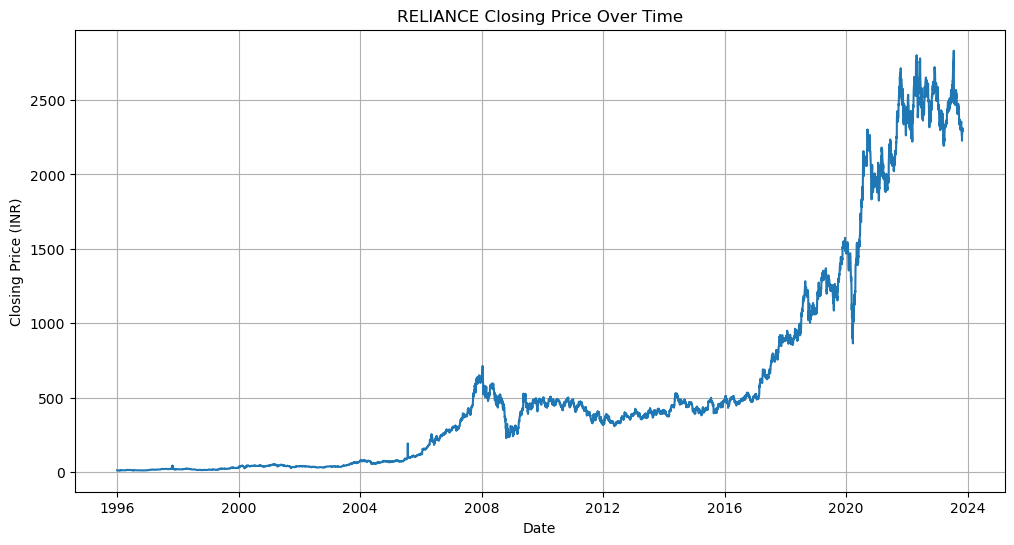

Shape of X: (6936, 60, 1)
Shape of y: (6936,)


In [4]:
# preprocessing
df['Date'] = pd.to_datetime(df['Date'])# Convert Date to datetime and sort
df = df.sort_values('Date')
# Visualize Close price trend
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'])
plt.title('RELIANCE Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (INR)')
plt.grid(True)
plt.show()
close_data = df[['Close']].values# Use Close prices only
scaler = MinMaxScaler(feature_range=(0, 1))# Scale between 0 and 1
scaled_close = scaler.fit_transform(close_data)
time_step = 60# Create sequences (60-day lookback)
X_list, y_list = [], []
for i in range(time_step, len(scaled_close)):
    X_list.append(scaled_close[i-time_step:i, 0])
    y_list.append(scaled_close[i, 0])
X = np.array(X_list)
y = np.array(y_list)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))# Reshape for LSTM [samples, time_steps, features]
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


In [5]:
train_size = int(len(X) * 0.8)#for splitting train and test data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (5548, 60, 1) (5548,)
Test shape: (1388, 60, 1) (1388,)


In [8]:
#build
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:

history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    verbose=1) #train model

Epoch 1/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 44s 160ms/step - loss: 5.4125e-04 - val_loss: 0.0011
Epoch 2/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 26s 147ms/step - loss: 3.1940e-05 - val_loss: 0.0022
Epoch 3/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 26s 151ms/step - loss: 3.1967e-05 - val_loss: 0.0014
Epoch 4/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - loss: 2.8857e-05 - val_loss: 0.0015
Epoch 5/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - loss: 3.0309e-05 - val_loss: 0.0020
Epoch 6/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 45s 261ms/step - loss: 2.5218e-05 - val_loss: 0.0020
Epoch 7/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 72s 202ms/step - loss: 2.4726e-05 - val_loss: 0.0015
Epoch 8/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - loss: 2.2792e-05 - val_loss: 7.1999e-04
Epoch 9/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 37s 212ms/step - loss: 2.3749e-05 - val_loss: 8.0048e-04
Epoch 10/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 46s 240ms/step - loss: 1.9978e-05 - val_loss: 8.2814e-04
Epoch 11/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 35s 201ms/step -

In [10]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)# Prediction
# Inverse transform to original price scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))#metrics
mae = mean_absolute_error(y_test_actual, test_predict)#metrics

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
RMSE: 81.55
MAE: 65.68


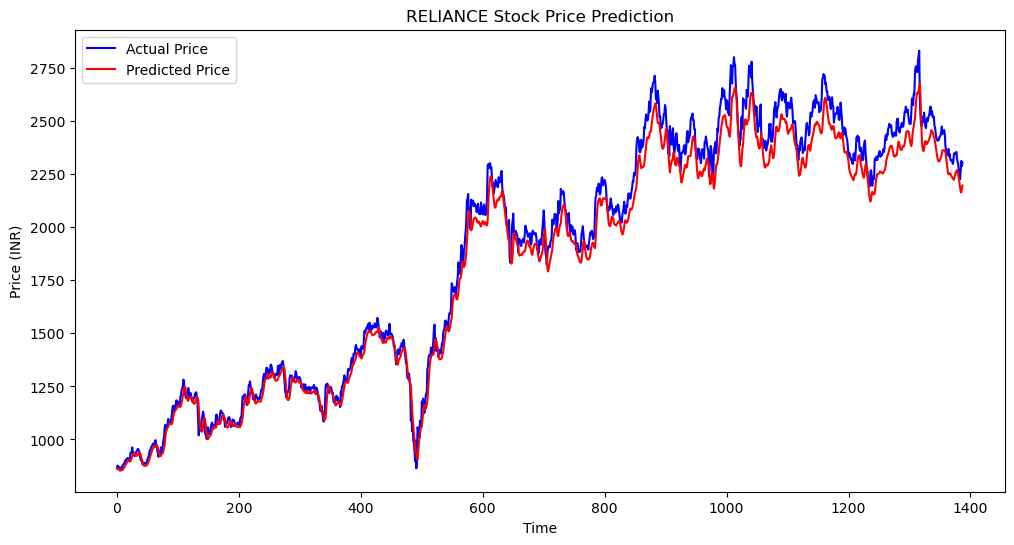

In [11]:
#visualization
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, color='blue', label='Actual Price')
plt.plot(test_predict, color='red', label='Predicted Price')
plt.title('RELIANCE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Predicted Future Closing Prices:
Day +1: ₹2210.88
Day +2: ₹2190.85
Day +3: ₹2160.82
Day +4: ₹2126.05
Day +5: ₹2089.08
Day +6: ₹2051.33
Day +7: ₹2013.71
Day +8: ₹1976.83
Day +9: ₹1941.14
Day +10: ₹1906.93


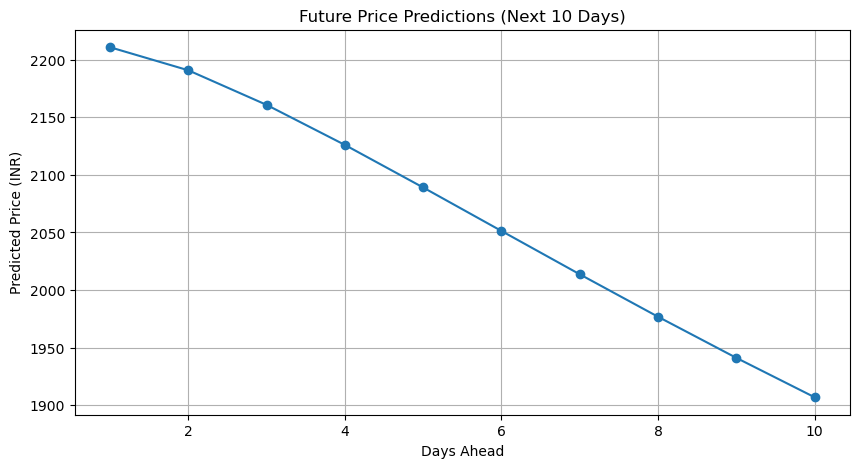

In [13]:
future_days = 10  #prediction for 10days 
last_sequence = scaled_close[-60:].reshape(1, 60, 1)# Start with the last 60 days from the scaled dataset
future_predictions = []
for _ in range(future_days):
    # Predict the next day
    next_scaled = model.predict(last_sequence)
    next_price = scaler.inverse_transform(next_scaled)[0][0]
    future_predictions.append(next_price)
    last_sequence = np.append(last_sequence[:, 1:, :], [[next_scaled[0]]], axis=1)# Update the sequence for the next iteration
print("Predicted Future Closing Prices:")
for i, price in enumerate(future_predictions, start=1):
    print(f"Day +{i}: ₹{price:.2f}")

# Plots
plt.figure(figsize=(10,5))
plt.plot(range(1, future_days+1), future_predictions, marker='o', linestyle='-')
plt.title(f"Future Price Predictions (Next {future_days} Days)")
plt.xlabel("Days Ahead")
plt.ylabel("Predicted Price (INR)")
plt.grid(True)
plt.show()
